In [1]:
import pandas as pd

In [2]:
import pandas as pd

df = pd.read_csv("sapmaintance.csv", encoding="ISO-8859-1", sep=";")
df.columns = df.columns.str.strip()

df["Data zawiadom."] = pd.to_datetime(df["Data zawiadom."], errors="coerce")
df = df[df["Data zawiadom."].notna()]
df = df[df["Data zawiadom."] >= "2020-01-01"]
df = df[df["Opis"].notna() & df["Nr zlec."].notna() & df["Oznaczenie"].notna()]
df["Nr zlec."] = df["Nr zlec."].astype("Int64")
df["Priorytet"] = df["Priorytet"].fillna("Brak")

df["Typ_zawiadomienia"] = df["Rodzaj zawiad."].apply(lambda x: "Awaria" if x == "1P" else "Prewencyjne")

df = df.sort_values(by=["Oznaczenie", "Data zawiadom."]).reset_index(drop=True)

df["Dni_od_ostatniej_awarii"] = df.groupby("Oznaczenie")["Data zawiadom."].diff().dt.days

last_preventive = {}
dzien_od_prewencji = []

for _, row in df.iterrows():
    machine = row["Oznaczenie"]
    current_date = row["Data zawiadom."]
    last = last_preventive.get(machine, pd.NaT)
    if pd.notna(last):
        days = (current_date - last).days
    else:
        days = None
    dzien_od_prewencji.append(days)

    if row["Typ_zawiadomienia"] == "Prewencyjne":
        last_preventive[machine] = current_date

df["Dni_od_ostatniej_prewencji"] = dzien_od_prewencji

df_failures = df[df["Typ_zawiadomienia"] == "Awaria"]
df_failures = df_failures[df_failures["Dni_od_ostatniej_awarii"].notna()]



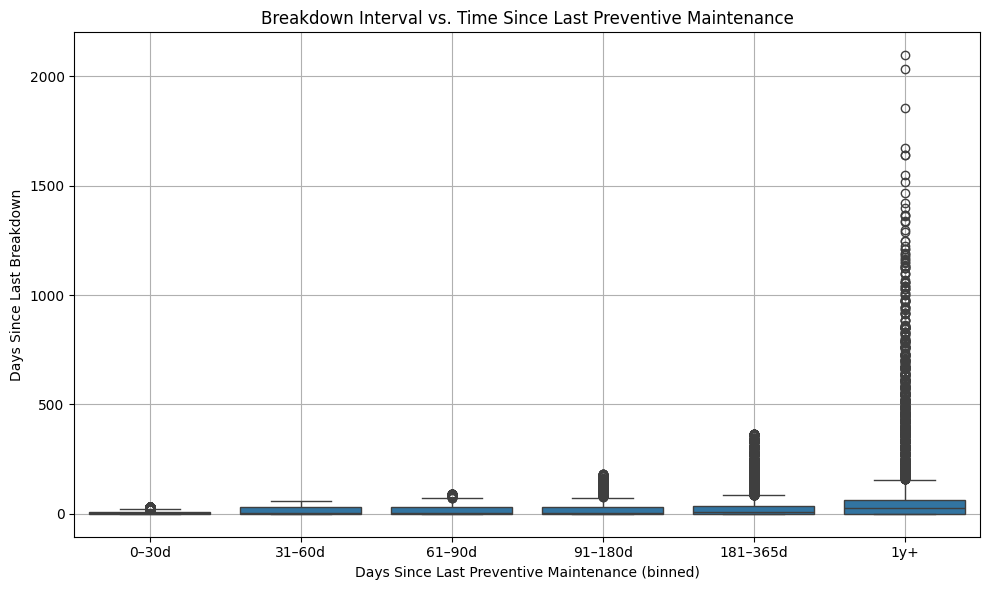

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_failures["bin_prewencja"] = pd.cut(
    df_failures["Dni_od_ostatniej_prewencji"],
    bins=[0, 30, 60, 90, 180, 365, 10000],
    labels=["0–30d", "31–60d", "61–90d", "91–180d", "181–365d", "1y+"]
)

plt.figure(figsize=(10, 6))
sns.boxplot(x="bin_prewencja", y="Dni_od_ostatniej_awarii", data=df_failures)
plt.title("Breakdown Interval vs. Time Since Last Preventive Maintenance")
plt.xlabel("Days Since Last Preventive Maintenance (binned)")
plt.ylabel("Days Since Last Breakdown")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

df_failures["Data zawiadom."] = pd.to_datetime(df_failures["Data zawiadom."], errors="coerce")

df_failures["Dzien_tygodnia"] = df_failures["Data zawiadom."].dt.day_name()

df_failures["Target_szybko_awaria"] = (df_failures["Dni_od_ostatniej_awarii"] < 30).astype(int)

model_df = df_failures.dropna(subset=["Dni_od_ostatniej_prewencji", "Dzien_tygodnia", "Priorytet", "Oznaczenie"])

X = model_df[["Oznaczenie", "Dzien_tygodnia", "Priorytet", "Dni_od_ostatniej_prewencji"]]
X = pd.get_dummies(X)
y = model_df["Target_szybko_awaria"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.51      0.54      1548
           1       0.80      0.83      0.82      3632

    accuracy                           0.74      5180
   macro avg       0.68      0.67      0.68      5180
weighted avg       0.73      0.74      0.73      5180

Confusion Matrix:
 [[ 791  757]
 [ 602 3030]]


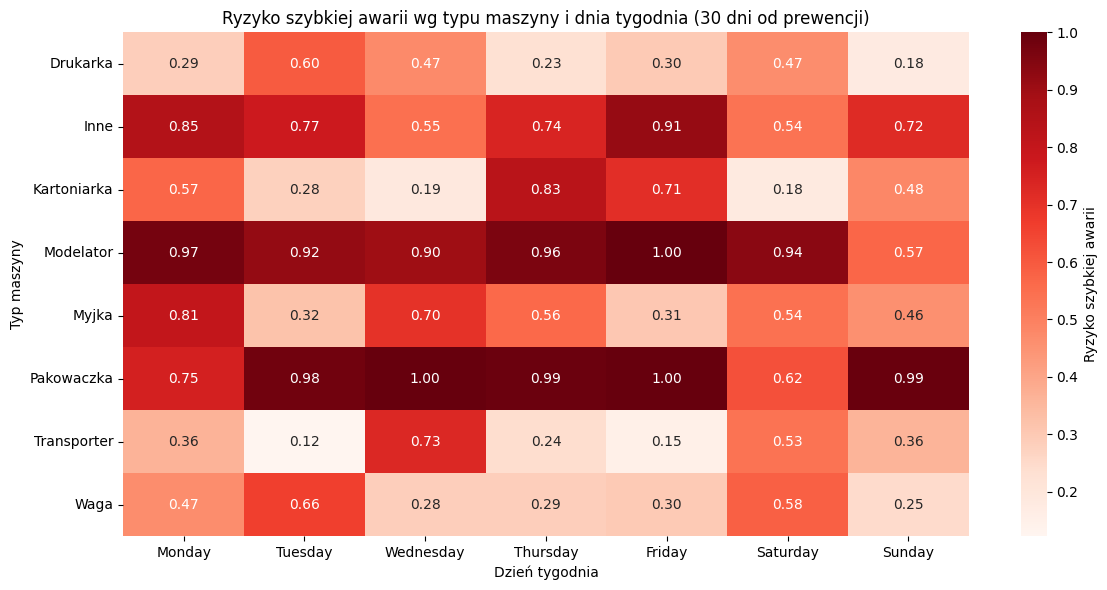

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import itertools

df_failures["Data zawiadom."] = pd.to_datetime(df_failures["Data zawiadom."], errors="coerce")
df_failures["Dzien_tygodnia"] = df_failures["Data zawiadom."].dt.day_name()
df_failures["Target_szybko_awaria"] = (df_failures["Dni_od_ostatniej_awarii"] < 30).astype(int)

df_failures["Typ_maszyny"] = df_failures["Oznaczenie"].str.extract(r"(Pakowaczka|Kartoniarka|Modelator|Zgrzewarka|Myjka|Maszyna pakująca|Transporter|Detektor|Drukarka|Waga)", expand=False)
df_failures["Typ_maszyny"] = df_failures["Typ_maszyny"].fillna("Inne")

model_df = df_failures.dropna(subset=["Dni_od_ostatniej_prewencji", "Dzien_tygodnia", "Priorytet", "Typ_maszyny"])
X = pd.get_dummies(model_df[["Typ_maszyny", "Dzien_tygodnia", "Priorytet", "Dni_od_ostatniej_prewencji"]])
y = model_df["Target_szybko_awaria"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

top_types = model_df["Typ_maszyny"].value_counts().head(8).index.tolist()
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
priority = "Brak"
prevention_days = 30

test_df = pd.DataFrame(itertools.product(top_types, days), columns=["Typ_maszyny", "Dzien_tygodnia"])
test_df["Priorytet"] = priority
test_df["Dni_od_ostatniej_prewencji"] = prevention_days

test_encoded = pd.get_dummies(test_df)
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)
test_df["Prawdopodobieństwo_szybkiej_awarii"] = rf_model.predict_proba(test_encoded)[:, 1]

pivot = test_df.pivot(index="Typ_maszyny", columns="Dzien_tygodnia", values="Prawdopodobieństwo_szybkiej_awarii")
pivot = pivot[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Ryzyko szybkiej awarii'})
plt.title(f"Ryzyko szybkiej awarii wg typu maszyny i dnia tygodnia ({prevention_days} dni od prewencji)")
plt.xlabel("Dzień tygodnia")
plt.ylabel("Typ maszyny")
plt.tight_layout()
plt.show()


/tmp/ipykernel_3635/1577676998.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_failures.groupby("Prevention_Bin")["Target_szybko_awaria"]


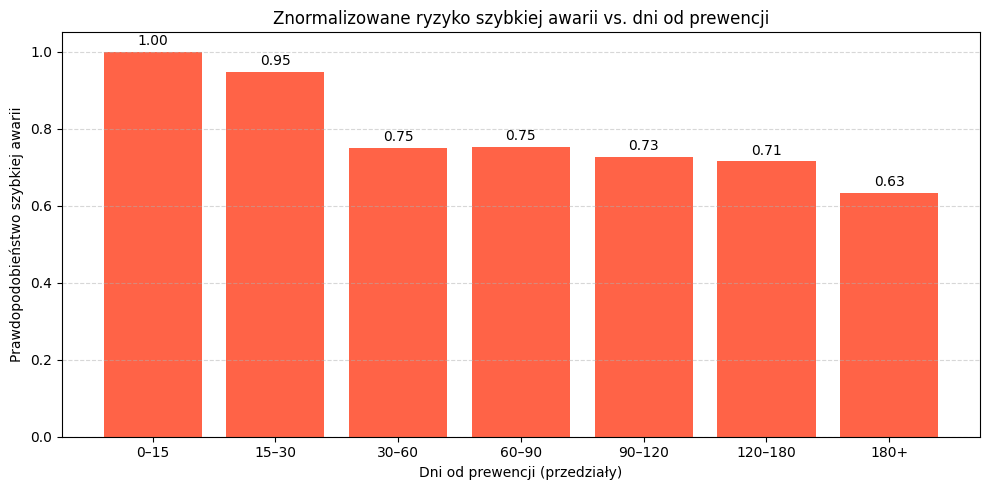

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

bins = [0, 15, 30, 60, 90, 120, 180, 999]
labels = ["0–15", "15–30", "30–60", "60–90", "90–120", "120–180", "180+"]
df_failures["Prevention_Bin"] = pd.cut(
    df_failures["Dni_od_ostatniej_prewencji"], bins=bins, labels=labels, include_lowest=True
)

grouped = df_failures.groupby("Prevention_Bin")["Target_szybko_awaria"]
summary = pd.DataFrame({
    "Total": grouped.count(),
    "Fast_Failures": grouped.sum()
})
summary["Ratio_Fast_Failure"] = summary["Fast_Failures"] / summary["Total"]

plt.figure(figsize=(10, 5))
bars = plt.bar(summary.index.astype(str), summary["Ratio_Fast_Failure"], color='tomato')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha='center', va='bottom')

plt.xlabel("Dni od prewencji (przedziały)")
plt.ylabel("Prawdopodobieństwo szybkiej awarii")
plt.title("Znormalizowane ryzyko szybkiej awarii vs. dni od prewencji")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200],                  # Number of trees
    'max_depth': [None, 10, 20],                 # Tree depth
    'min_samples_split': [2, 5, 10],             # Min samples to split
    'min_samples_leaf': [1, 2, 4],               # Min samples at leaf
    'max_features': ['sqrt', 'log2']             # Number of features to consider at each split
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1, scoring="f1")  # Use scoring='accuracy' or 'f1' depending on needs
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


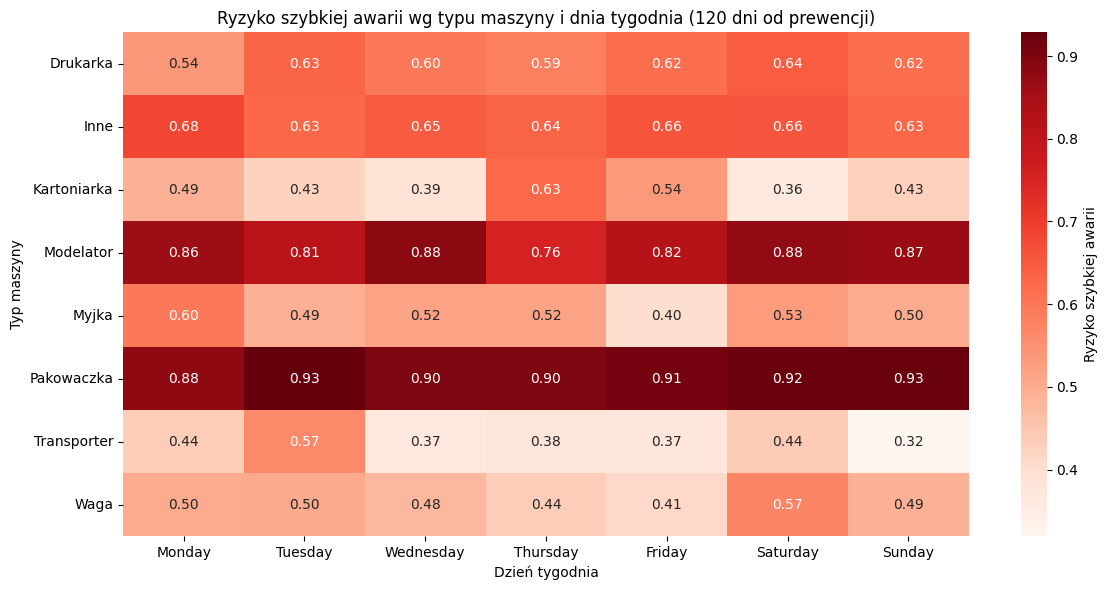

In [9]:
best_model.fit(X_train, y_train)

top_types = model_df["Typ_maszyny"].value_counts().head(8).index.tolist()
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
priority = "Brak"
prevention_days = 120

test_df = pd.DataFrame(itertools.product(top_types, days), columns=["Typ_maszyny", "Dzien_tygodnia"])
test_df["Priorytet"] = priority
test_df["Dni_od_ostatniej_prewencji"] = prevention_days

test_encoded = pd.get_dummies(test_df)
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)
test_df["Prawdopodobieństwo_szybkiej_awarii"] = best_model.predict_proba(test_encoded)[:, 1]

pivot = test_df.pivot(index="Typ_maszyny", columns="Dzien_tygodnia", values="Prawdopodobieństwo_szybkiej_awarii")
pivot = pivot[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Ryzyko szybkiej awarii'})
plt.title(f"Ryzyko szybkiej awarii wg typu maszyny i dnia tygodnia ({prevention_days} dni od prewencji)")
plt.xlabel("Dzień tygodnia")
plt.ylabel("Typ maszyny")
plt.tight_layout()
plt.show()

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:47:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


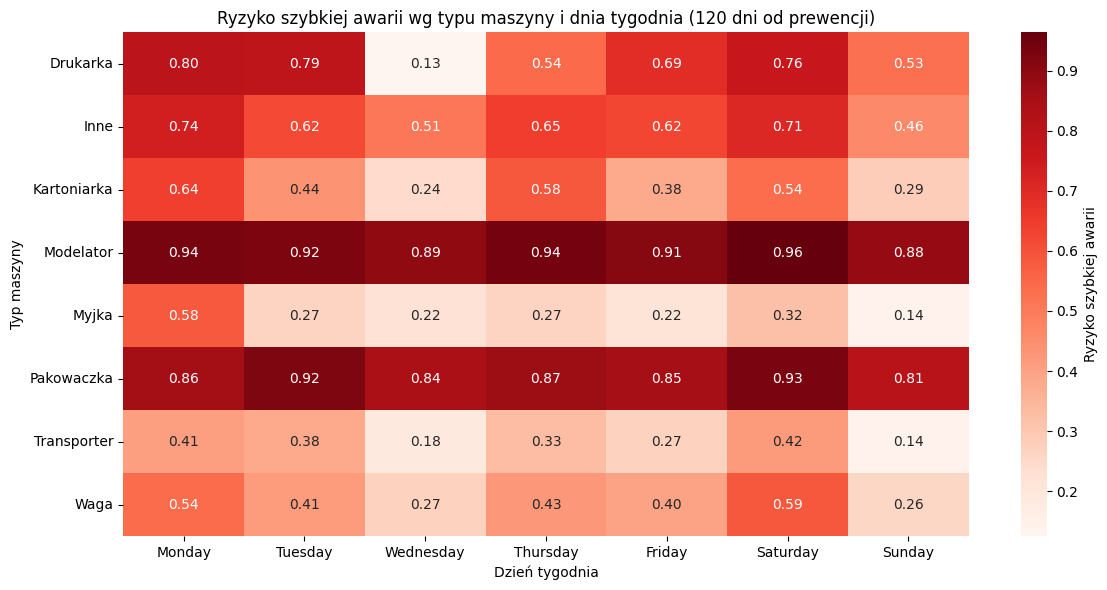

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import itertools

df_failures["Data zawiadom."] = pd.to_datetime(df_failures["Data zawiadom."], errors="coerce")
df_failures["Dzien_tygodnia"] = df_failures["Data zawiadom."].dt.day_name()
df_failures["Target_szybko_awaria"] = (df_failures["Dni_od_ostatniej_awarii"] < 30).astype(int)

df_failures["Typ_maszyny"] = df_failures["Oznaczenie"].str.extract(
    r"(Pakowaczka|Kartoniarka|Modelator|Zgrzewarka|Myjka|Maszyna pakująca|Transporter|Detektor|Drukarka|Waga)", 
    expand=False
)
df_failures["Typ_maszyny"] = df_failures["Typ_maszyny"].fillna("Inne")

model_df = df_failures.dropna(subset=["Dni_od_ostatniej_prewencji", "Dzien_tygodnia", "Priorytet", "Typ_maszyny"])

X = pd.get_dummies(model_df[["Typ_maszyny", "Dzien_tygodnia", "Priorytet", "Dni_od_ostatniej_prewencji"]])
y = model_df["Target_szybko_awaria"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

top_types = model_df["Typ_maszyny"].value_counts().head(8).index.tolist()
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
priority = "Brak"
prevention_days = 120

test_df = pd.DataFrame(itertools.product(top_types, days), columns=["Typ_maszyny", "Dzien_tygodnia"])
test_df["Priorytet"] = priority
test_df["Dni_od_ostatniej_prewencji"] = prevention_days

test_encoded = pd.get_dummies(test_df)
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)

test_df["Prawdopodobieństwo_szybkiej_awarii"] = xgb_model.predict_proba(test_encoded)[:, 1]

pivot = test_df.pivot(index="Typ_maszyny", columns="Dzien_tygodnia", values="Prawdopodobieństwo_szybkiej_awarii")
pivot = pivot[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Ryzyko szybkiej awarii'})
plt.title(f"Ryzyko szybkiej awarii wg typu maszyny i dnia tygodnia ({prevention_days} dni od prewencji)")
plt.xlabel("Dzień tygodnia")
plt.ylabel("Typ maszyny")
plt.tight_layout()
plt.show()


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_rf = rf_model.predict(X_test)
print("Random Forest (Tuned) Report:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

Random Forest (Tuned) Report:
              precision    recall  f1-score   support

           0       0.44      0.35      0.39      1548
           1       0.75      0.81      0.78      3632

    accuracy                           0.67      5180
   macro avg       0.60      0.58      0.59      5180
weighted avg       0.66      0.67      0.66      5180

[[ 546 1002]
 [ 682 2950]]
XGBoost Report:
              precision    recall  f1-score   support

           0       0.53      0.27      0.36      1548
           1       0.74      0.90      0.81      3632

    accuracy                           0.71      5180
   macro avg       0.64      0.58      0.59      5180
weighted avg       0.68      0.71      0.68      5180

[[ 424 1124]
 [ 379 3253]]


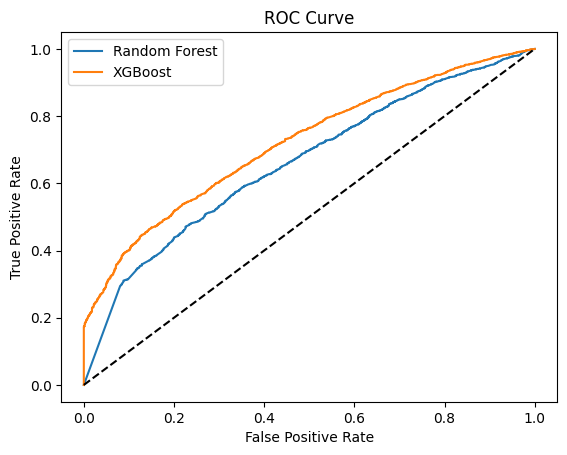

In [13]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])

plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score
print("Random Forest AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
print("XGBoost AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))


Random Forest AUC: 0.6612763804938019
XGBoost AUC: 0.7195102711755399
